In [1]:
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework import ops

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('ggplot')

In [2]:
!../scripts/copy_data.sh

In [3]:
DATA_PATH = '../data/'

In [4]:
def read(filepath, pred=False):
    dat = pd.read_csv(filepath)
    if not pred:
        dat['buyDate'] = pd.to_datetime(dat['buyDate'])
    return dat

In [5]:
ls -la ../data

total 2392
drwxr-xr-x   6 dsp  staff      204 Jul 13 21:00 ./
drwxr-xr-x  11 dsp  staff      374 Jul  1 16:27 ../
-rw-r--r--@  1 dsp  staff     6148 Jul 13 21:00 .DS_Store
-rw-r--r--@  1 dsp  staff     1749 Sep 16 16:48 Multistock.csv
-rw-r--r--@  1 dsp  staff    36770 Sep 16 16:48 buyStats.csv
-rw-r--r--@  1 dsp  staff  1174245 Sep 16 13:43 sp1950.csv


In [6]:
dat = read(DATA_PATH + 'buyStats.csv')
#new_dat = read(DATA_PATH + 'Multistock.csv', pred=True)
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,stockMACD,stockPmoB,stockPmoW,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days
0,adbe,0,131.72,2017-04-21,148,136.43,1.03576,141.21,1.07205,149.07,...,-0.066,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
1,jblu,0,21.46,2017-04-21,148,21.18,0.98695,22.74,1.05965,23.33,...,0.250,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
2,tsco,0,63.35,2017-04-21,148,57.57,0.90876,55.69,0.87908,51.70,...,-1.254,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
3,ftnt,0,40.16,2017-04-25,144,39.94,0.99452,38.29,0.95344,40.45,...,0.504,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388
4,pac,0,101.15,2017-04-25,144,109.00,1.07761,110.45,1.09194,117.90,...,0.633,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388


In [7]:
def one_hot(df):
    X = df.copy()
    X[['mfNone', 'mfNow', 'mfStart']] = pd.get_dummies(X['MF'])
    X = X.drop('MF', axis=1)
    return X

In [8]:
dat = one_hot(dat)
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days,mfNone,mfNow,mfStart
0,adbe,0,131.72,2017-04-21,148,136.43,1.03576,141.21,1.07205,149.07,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
1,jblu,0,21.46,2017-04-21,148,21.18,0.98695,22.74,1.05965,23.33,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
2,tsco,0,63.35,2017-04-21,148,57.57,0.90876,55.69,0.87908,51.70,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
3,ftnt,0,40.16,2017-04-25,144,39.94,0.99452,38.29,0.95344,40.45,...,2374.0,-7.14,NaN,NaN,NaN,10.84,41388,0,1,0
4,pac,0,101.15,2017-04-25,144,109.00,1.07761,110.45,1.09194,117.90,...,2374.0,-7.14,NaN,NaN,NaN,10.84,41388,0,1,0


In [9]:
today = datetime.datetime.now()
if today.weekday() == 5:
    today = today - datetime.timedelta(days=1)
if today.weekday() == 6:
    today = today - datetime.timedelta(days=2)
today = str(today).split(' ')[0]
today = pd.to_datetime(today)
today

Timestamp('2017-09-15 00:00:00')

In [10]:
new_dat = dat.loc[dat['buyDate'] > today, :]
dat     = dat.loc[dat['buyDate'] <= today, :]
stocks = new_dat['stock']
new_dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days,mfNone,mfNow,mfStart
177,mmm,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,0,1,0
178,ccoi,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,1,0,0
179,or,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,1,0,0
180,ato,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,1,0,0


In [11]:
def drop_missing(dfs, y_col):
    X = dfs[0].copy()
    # cols
    drop_cols = [col for col in list(X) if type(col[0]) == np.float and col.isnan().all()]
    X = X.drop(drop_cols, axis=1)
    X2 = dfs[1].drop(drop_cols, axis=1)
    return X.loc[np.isnan(dat[y_col]) == False, :], X2

In [12]:
dat, new_dat = drop_missing([dat, new_dat], 'd30Gains')
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days,mfNone,mfNow,mfStart
0,adbe,0,131.72,2017-04-21,148,136.43,1.03576,141.21,1.07205,149.07,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
1,jblu,0,21.46,2017-04-21,148,21.18,0.98695,22.74,1.05965,23.33,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
2,tsco,0,63.35,2017-04-21,148,57.57,0.90876,55.69,0.87908,51.70,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
3,ftnt,0,40.16,2017-04-25,144,39.94,0.99452,38.29,0.95344,40.45,...,2374.0,-7.14,NaN,NaN,NaN,10.84,41388,0,1,0
4,pac,0,101.15,2017-04-25,144,109.00,1.07761,110.45,1.09194,117.90,...,2374.0,-7.14,NaN,NaN,NaN,10.84,41388,0,1,0


In [13]:
new_dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days,mfNone,mfNow,mfStart
177,mmm,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,0,1,0
178,ccoi,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,1,0,0
179,or,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,1,0,0
180,ato,0,NaN,2017-09-18,-2,NaN,NaN,NaN,NaN,NaN,...,2500.23,10.055,64.94,0.4,0.4,10.17,41534,1,0,0


In [14]:
def split_xy(df, y_col, first_X):
    y = df[y_col]
    start_col = list(df).index(first_X)
    X = df.iloc[:, start_col:]
    return X, y

In [15]:
#list(dat)

In [16]:
X, y         = split_xy(dat,     'd30Gains', 'MFRisk')
X_new, y_new = split_xy(new_dat, 'd30Gains', 'MFRisk')

In [17]:
#print(list(X) == list(X_new))
[print('Mismatch:', x, xn) for (x, xn) in zip(list(X), list(X_new)) if x != xn]
[(x, xn) for (x, xn) in zip(list(X), list(X_new))]

[('MFRisk', 'MFRisk'),
 ('n_L52', 'n_L52'),
 ('n_H52', 'n_H52'),
 ('pE', 'pE'),
 ('pB', 'pB'),
 ('revG5', 'revG5'),
 ('freeCashFlow', 'freeCashFlow'),
 ('grossMarQ', 'grossMarQ'),
 ('opMarQ', 'opMarQ'),
 ('roaTTM', 'roaTTM'),
 ('roiQ', 'roiQ'),
 ('roiTTM', 'roiTTM'),
 ('totDEQ', 'totDEQ'),
 ('Fid', 'Fid'),
 ('FidBest', 'FidBest'),
 ('RSI14', 'RSI14'),
 ('stockMACD', 'stockMACD'),
 ('stockPmoB', 'stockPmoB'),
 ('stockPmoW', 'stockPmoW'),
 ('spVal', 'spVal'),
 ('macd', 'macd'),
 ('spRSI14', 'spRSI14'),
 ('spPmoB75_40_20', 'spPmoB75_40_20'),
 ('spPmoW75_40_20', 'spPmoW75_40_20'),
 ('vix', 'vix'),
 ('days', 'days'),
 ('mfNone', 'mfNone'),
 ('mfNow', 'mfNow'),
 ('mfStart', 'mfStart')]

In [18]:
def median_fill(df):
    X = df.copy()

    for col in list(X):
        try:
            X[col][np.isnan(X[col])] = np.nanmedian(X[col])
        except:
            print('Could not fill column', col)
    return X

In [19]:
X = median_fill(X)
X_new = median_fill(X_new)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
X.shape

(132, 29)

In [21]:
n = X.shape[0]
TRAIN = 0.7
VALIDATE = 0.15
TEST = 0.15
print(
    'Training size:   %.0f\nValidation size: %.0f\nTest       size: %.0f'
    %(TRAIN * n, VALIDATE * n, TEST * n))

Training size:   92
Validation size: 20
Test       size: 20


In [22]:
# Train, Not Train
X_train, X_vt, y_train, y_vt = train_test_split(
    X, y, test_size=VALIDATE + TEST)

# Validate Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_vt, y_vt, test_size=(TEST / (TEST + VALIDATE)))

# Reindex
X_train.index = range(len(y_train))
y_train.index = range(len(y_train))

X_valid.index = range(len(y_valid))
y_valid.index = range(len(y_valid))

X_test.index = range(len(y_test))
y_test.index = range(len(y_test))
y_test = y_test.values.reshape(-1, 1)

In [23]:
#X.head()

In [24]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(X_new.shape)

(92, 29)
(20, 29)
(20, 29)
(4, 29)


In [25]:
# WHILE DATA SET IS SMALL, restrict values in new data to the range seen 
# in training data
if X_test.shape[0] < 100:
    for col in list(X_train):
        if col not in ['spVal', 'days']:
            mn, mx = np.min(X_train[col]), np.max(X_train[col])
            X_new[col][X_new[col] < mn] = mn
            X_new[col][X_new[col] > mx] = mx

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
for col in list(X_train):
    if np.isnan(X_train[col]).any():
        print(col)

In [29]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_new  = scaler.transform(X_new)

## Create Neural Net

In [30]:
# Create a fully-connected layer of neurons using dropout regularization
def make_drop_layer(in_layer,
                    n_out,
                    activation,
                    kernel_initializer,
                    dropout_rate,
                    training):
    h = tf.layers.dense(in_layer,
                        n_out,
                        activation=activation,
                        kernel_initializer=kernel_initializer)
    h_drop = tf.layers.dropout(h, rate=dropout_rate, training=training)
    return h_drop

In [31]:
X_train.shape

(92, 29)

In [32]:
# Run only before first model is executed
best_error_so_far = np.Inf

In [33]:
# Rerun models from here
N, D = X_train.shape

# Hyperparmeters to tune
DROPOUT_RATE = 0
n_neurons = [D, 2 * D,  2 * D, D, D, D, 1]

# Progrmmed Learning with Decay
ETA = 0.1 # Learning rate
DECAY_STEPS = 100  # eta updates after this many epochs
DECAY_RATE = 0.99  # factor to change eta by

In [34]:
ops.reset_default_graph()
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [35]:
X = tf.placeholder(tf.float32, shape=[None, D], name='X')
y = tf.placeholder(tf.float32, shape=None, name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

X_drop = tf.layers.dropout(X, DROPOUT_RATE, training=training)

In [36]:
with tf.name_scope('dnn'):
    # He intialization randomly initalizes weigths and their variances in 
    # a way that minimizes the likelihood of vanishing/exploding gradients
    he_init = tf.contrib.layers.variance_scaling_initializer()
    current_in = X

    for layer in range(1, len(n_neurons)):
        current_in = make_drop_layer(
            in_layer=current_in,
            n_out=n_neurons[layer],
            activation=tf.nn.tanh if (layer + 1) < len(n_neurons) else None,
            kernel_initializer=he_init,
            dropout_rate=DROPOUT_RATE,
            training=training)

    preds = tf.nn.relu(current_in)

In [37]:
with tf.name_scope('cost'):
    cost = tf.reduce_sum(tf.pow(preds - y, 2)) # SSE

In [38]:
with tf.name_scope('train'):
    eta0 = ETA # initial learning rate
    decay_steps = DECAY_STEPS  # eta updates after this many epochs
    decay_rate = DECAY_RATE    # factor to change eta by
    global_step = tf.Variable(0, trainable=False, name='global_step')
    eta = tf.train.exponential_decay(
        eta0, global_step, decay_steps, decay_rate, name='eta')
    optimizer = tf.train.AdamOptimizer(eta).minimize(
        cost, global_step=global_step)

In [39]:
epochs = 10000
batch_size = 20
train_err = []
valid_err = []
saver = tf.train.Saver()

In [40]:
# TODO: add batch regularization

In [41]:
with tf.Session() as s:
    s.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        idxs = np.random.permutation(range(N))
        n_batches = len(idxs) // batch_size

        for batch in range(n_batches):
            idx = idxs[batch * batch_size : (batch + 1) * batch_size]
            s.run(optimizer, feed_dict={training: True,
                                        X: X_train[idx, :],
                                        y: y_train[idx]})
        err_train = cost.eval(feed_dict={X: X_train[idx, :],
                                         y: y_train[idx]}) 
        err_valid = (cost.eval(feed_dict={X: X_valid, y: y_valid}))

        # Convert from SSE to MSE so train and valid can be compared 
        err_train /= y_train.shape[0]
        err_valid /= y_valid.shape[0]

        train_err.append(err_train)
        valid_err.append(err_valid)

        if epoch % 100 == 0:
            print(
                '%4d: Train error: %.5f\tValidation error: %.5f'
                %(epoch, err_train, err_valid))

    save_path = saver.save(s, './nn_mod.ckpt')

   0: Train error: 5.97019	Validation error: 28.01664
 100: Train error: 0.29440	Validation error: 0.67446
 200: Train error: 0.30963	Validation error: 0.44576
 300: Train error: 0.05632	Validation error: 0.16804
 400: Train error: 0.02247	Validation error: 0.28777
 500: Train error: 0.09361	Validation error: 1.11337
 600: Train error: 0.17066	Validation error: 2.13889
 700: Train error: 0.04713	Validation error: 0.18451
 800: Train error: 0.04077	Validation error: 0.16663
 900: Train error: 0.07563	Validation error: 0.16290
1000: Train error: 0.06030	Validation error: 0.20834
1100: Train error: 0.06913	Validation error: 0.34196
1200: Train error: 0.07442	Validation error: 0.25070
1300: Train error: 0.07341	Validation error: 0.19964
1400: Train error: 0.09471	Validation error: 0.29320
1500: Train error: 0.09284	Validation error: 0.47148
1600: Train error: 0.05282	Validation error: 0.16100
1700: Train error: 0.06822	Validation error: 0.34152
1800: Train error: 0.04070	Validation error: 

In [42]:
appx_validation_error = np.mean(valid_err[-N:])
print('Previous Best:', best_error_so_far)
print('This run:     ', appx_validation_error)

Previous Best: inf
This run:      0.164910820386


In [43]:
if appx_validation_error < best_error_so_far:
    best_error_so_far = appx_validation_error
    print('New Best Model Found!\nHyperparameters:\n' + ('-' * 70))
    hyperparams = {
        'best_error_so_far': appx_validation_error,
        'best_droupout': DROPOUT_RATE,
        'best_architecture': n_neurons,
        'best_eta': ETA,
        'best_decay_steps': DECAY_STEPS,
        'best_decay_rate': DECAY_RATE}
for k, v in hyperparams.items():
    print('%17s: %s' %(k, str(v)))

New Best Model Found!
Hyperparameters:
----------------------------------------------------------------------
best_error_so_far: 0.164910820386
    best_droupout: 0
best_architecture: [29, 58, 58, 29, 29, 29, 1]
         best_eta: 0.1
 best_decay_steps: 100
  best_decay_rate: 0.99


In [44]:
# TO DO: Search over hyperparameter space

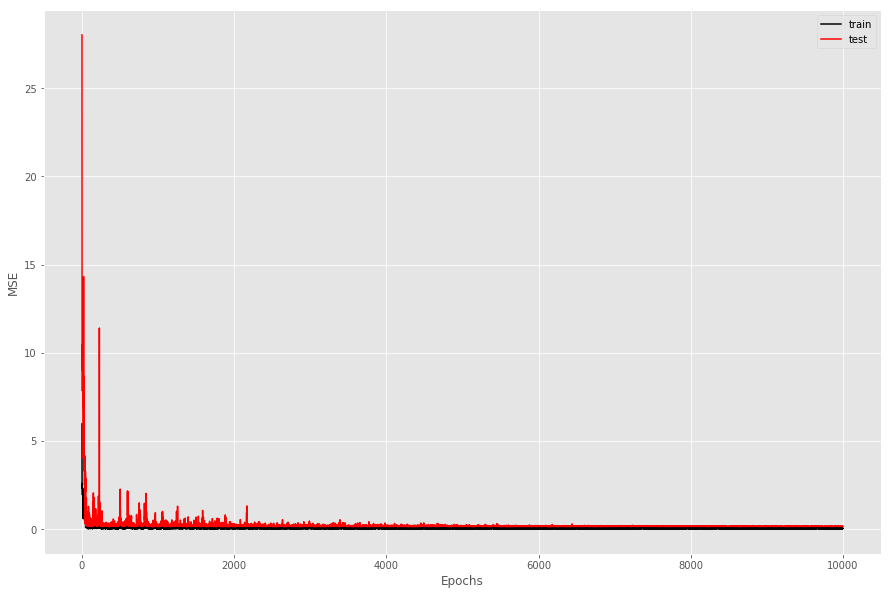

In [45]:
plt.plot(train_err, 'k-', label='train');
plt.plot(valid_err, 'r-', label='test');
plt.legend(loc='best');
plt.xlabel('Epochs');
plt.ylabel('MSE');

In [46]:
s = tf.Session()
saver = tf.train.Saver()
saver.restore(s, './nn_mod.ckpt')
test_preds = s.run(preds, feed_dict={X: X_test})

In [50]:
test_err = ((test_preds - y_test) ** 2).sum() / y_test.shape[0]
test_err

0.0097568744494577336

In [48]:
new_preds = s.run(preds, feed_dict={X: X_new})

In [52]:
final_out = []
for stock, pred in zip(stocks, new_preds.reshape(new_preds.shape[0])):
    final_out.append([stock, pred])
    
out = pd.DataFrame(columns=['Stock', 'Prediction'], data=final_out)
out['LowerBound'] = out['Prediction'] - 2*test_err
out['UpperBound'] = out['Prediction'] + 2*test_err
out = out.sort_values('Prediction', ascending=False)
out.head(len(stocks))

,Stock,Prediction,LowerBound,UpperBound
3,ato,1.017522,0.998008,1.037036
1,ccoi,1.015228,0.995714,1.034742
2,or,1.015043,0.995529,1.034557
0,mmm,1.006847,0.987333,1.026360
